In [2]:
import io

import pandas as pd
import numpy as np
import missingno as msng

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn_pandas import CategoricalImputer

from sklearn.preprocessing import StandardScaler , MinMaxScaler , LabelEncoder
from sklearn.manifold import TSNE 
from imblearn.over_sampling import SMOTE 
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split,KFold,StratifiedKFold

from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score,roc_curve, f1_score , confusion_matrix , classification_report

In [3]:
from google.colab import files
uploaded = files.upload()

Saving bank-additional-full.csv to bank-additional-full (1).csv


In [4]:
data =pd.read_csv(io.BytesIO(uploaded['bank-additional-full.csv']),delimiter=";")

In [5]:
data.head().append(data.tail())

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,239,3,999,1,failure,-1.1,94.767,-50.8,1.028,4963.6,no


In [6]:
print("The data has {} rows with {} features/columns".format(data.shape[0], data.shape[1]))

The data has 41188 rows with 21 features/columns


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

**Missing values**

> The missing values are represented by Nan which cannot be detected by using

> `data.isnull().sum().sum()`

>directly, so we change the values to what can be detected










In [8]:
print("The number of missing value(s): {}".format(data.isnull().sum().sum()))

The number of missing value(s): 0


In [9]:
data = data.replace("unknown",np.NaN)

In [10]:
print("The number of missing value(s): {}".format(data.isnull().sum().sum()))

The number of missing value(s): 12718


In [11]:
data.isnull().sum()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

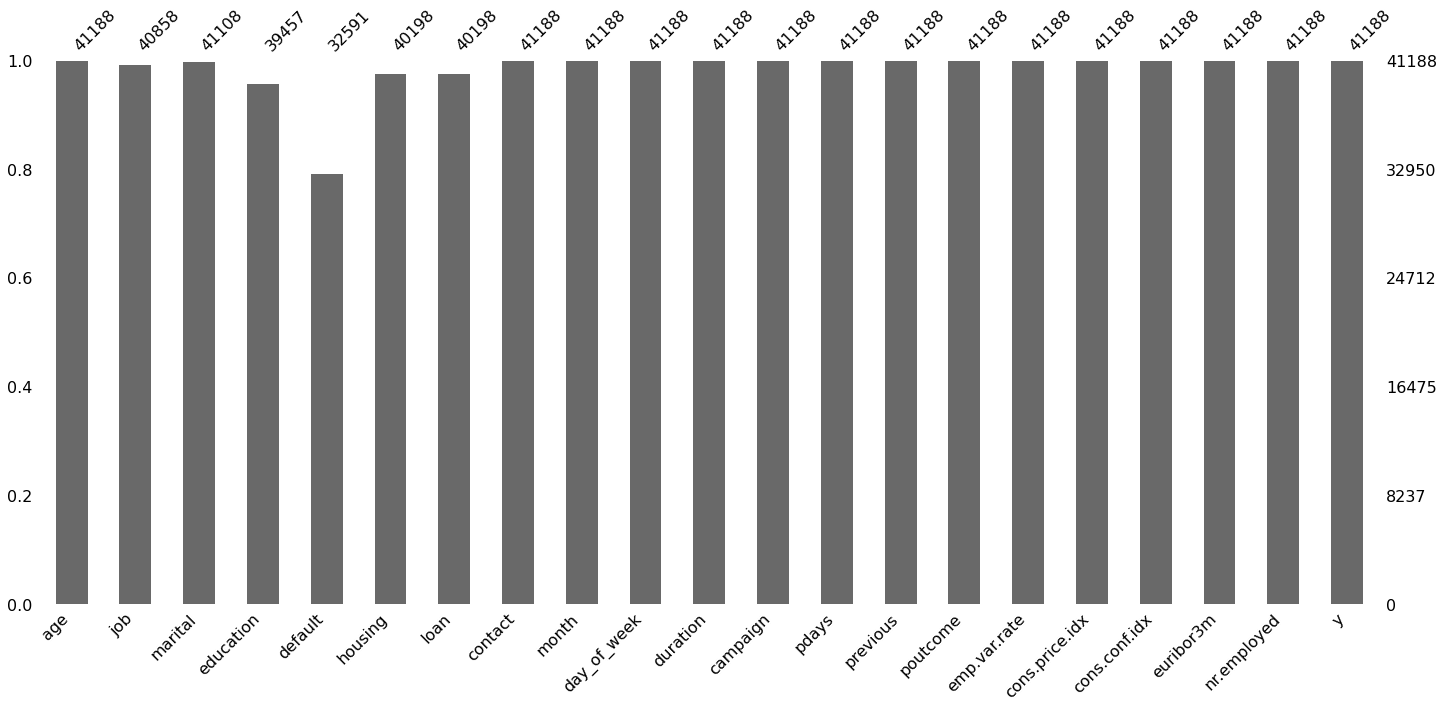

In [12]:
msng.bar(data)

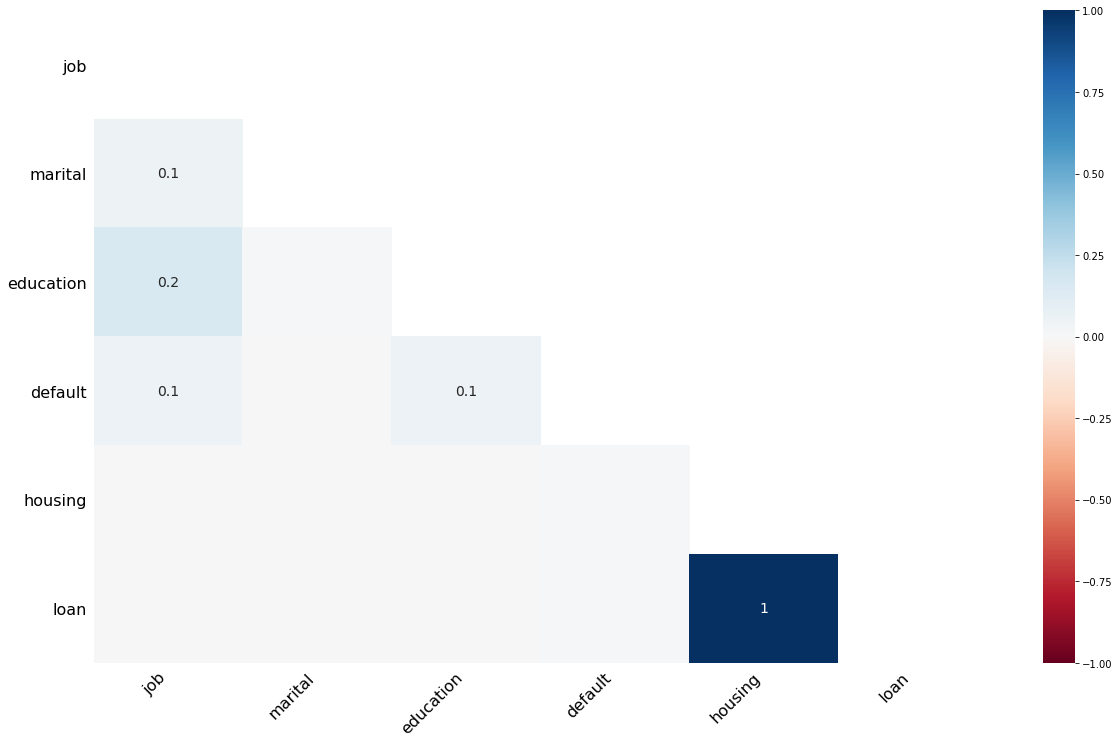

In [13]:
msng.heatmap(data)

The highest correlation is between “Loan” and “Housing” which is 1. This shows that these columns have missing values in the same rows.

Dealing with missing values

In [14]:
class DWMV:
  def __init__(self):
    pass
  def dropRow(self,data,feature):
    data = data[data[feature].notna()]
  def fillWithMode(self,data,feature):
    data = data.fillna(data[feature].value_counts().index[0], inplace=True)
    



In [15]:
filler = DWMV()
for feature in ['job','marital','education','housing','default','loan']:
  filler.fillWithMode(data,feature)

In [16]:
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Data Preprocessing

In [17]:
data.select_dtypes(include='object').columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

In [25]:
class Preprocess:
  def __init__(self):
    pass

  def oneHotEncoding(self,data):
    catColumns = data.select_dtypes(include='object').columns
    dummy_pre = [("is_"+ x) for x in catColumns]
    data = pd.get_dummies(data,prefix=dummy_pre,columns=catColumns)
    return data

  def labelEncoding(self,data,label):
    labelEncode = LabelEncoder()
    data[label] = labelEncode.fit_transform(data[label])
    return data[label]

  def normalize(self,data,feature):
    scaler = StandardScaler()
    fit_scaler = scaler.fit(data[feature].values)
    data[feature] = fit_scaler.transform(data[feature].values)
    return data
  
  def TSNE_(self,data):
    tsne = TSNE(n_components=3,n_iter=300,verbose=1)
    fit_tsne = tsne.fit_transform(data)
    return fit_tsne

  
     

In [19]:
 preprocess = Preprocess()
 data_feature = preprocess.oneHotEncoding(data.drop(columns='y'))

In [20]:
data_label =  preprocess.labelEncoding(data,'y')

In [21]:
numColumns = data_feature.select_dtypes(include=['int64','float64']).columns
numColumns = [x for x in numColumns if x not in ('campaign','previous')]

In [22]:
data_feature = preprocess.normalize(data_feature,numColumns)

In [27]:
tsne_fit = preprocess.TSNE_(data_feature)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 41188 samples in 0.493s...
[t-SNE] Computed neighbors for 41188 samples in 134.452s...
[t-SNE] Computed conditional probabilities for sample 1000 / 41188
[t-SNE] Computed conditional probabilities for sample 2000 / 41188
[t-SNE] Computed conditional probabilities for sample 3000 / 41188
[t-SNE] Computed conditional probabilities for sample 4000 / 41188
[t-SNE] Computed conditional probabilities for sample 5000 / 41188
[t-SNE] Computed conditional probabilities for sample 6000 / 41188
[t-SNE] Computed conditional probabilities for sample 7000 / 41188
[t-SNE] Computed conditional probabilities for sample 8000 / 41188
[t-SNE] Computed conditional probabilities for sample 9000 / 41188
[t-SNE] Computed conditional probabilities for sample 10000 / 41188
[t-SNE] Computed conditional probabilities for sample 11000 / 41188
[t-SNE] Computed conditional probabilities for sample 12000 / 41188
[t-SNE] Computed conditional probabilities for s

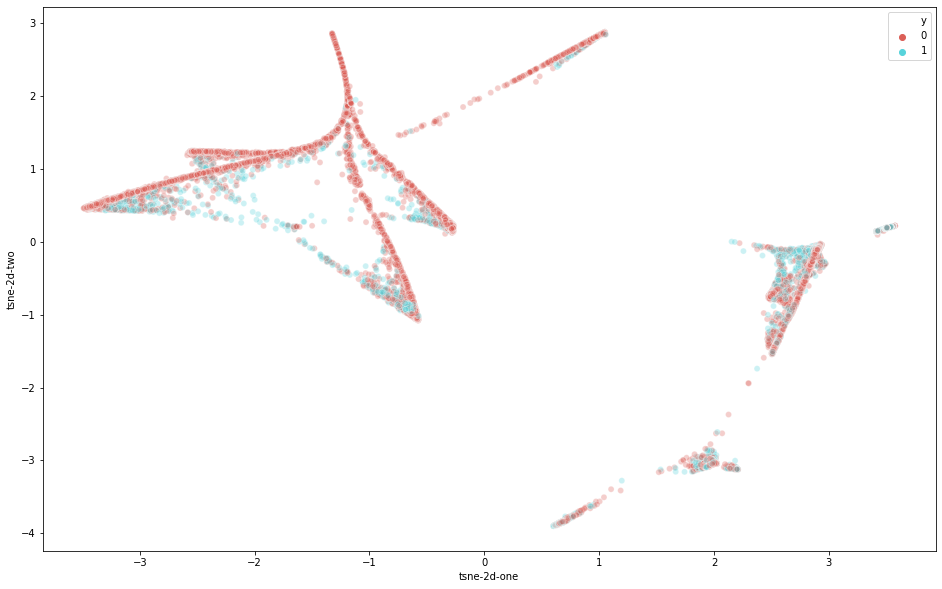

In [31]:
tsne_data = data_feature.copy()
tsne_data['tsne-2d-one'] = tsne_fit[:,0]
tsne_data['tsne-2d-two'] = tsne_fit[:,1]
tsne_data['y'] = data_label
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=tsne_data,
    legend="full",
    alpha=0.3
)

In [34]:
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(data_feature)


In [39]:
data_pca = data_feature.copy()
data_pca['pca-one'] = pca_fit[:,0]
data_pca['pca-two'] = pca_fit[:,1] 
data_pca['y'] = data_label
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.36408058 0.17053046]


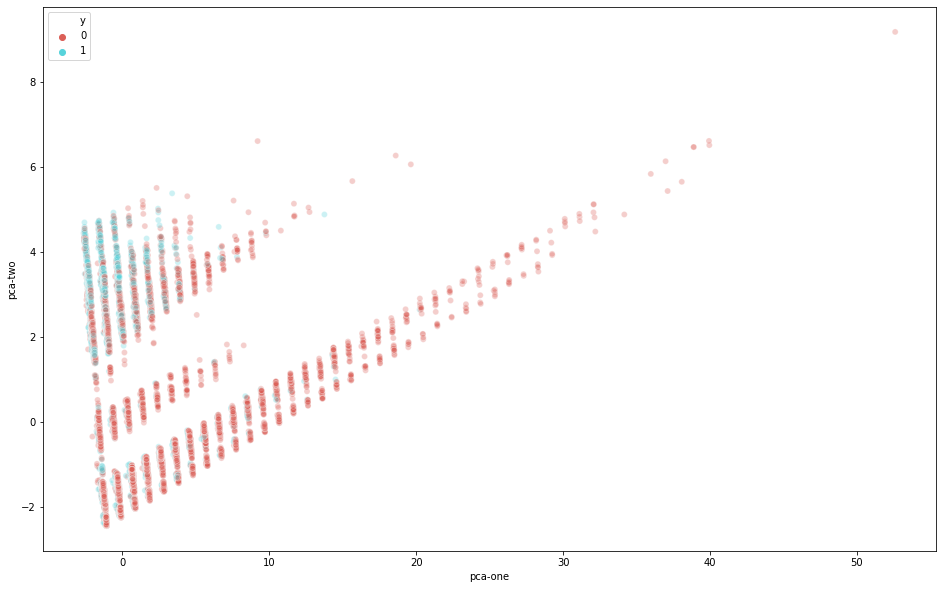

In [40]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=data_pca,
    legend="full",
    alpha=0.3
)

In [42]:
class modelPlusFold:
    def __init__(self):
        pass
    
    def modelKfold(self, model, x, y):
        
        # A list to append all the score for each fold
        rocScores = []
        f1Scores = []

        # split the data further using KFold
        cv = KFold(n_splits=5,random_state=42, shuffle=True)
        for trainIndex, testIndex in cv.split(x):

            cvXTrain, cvXTest = x[trainIndex], x[testIndex]
            cvYTrain, cvYTest = y[trainIndex], y[testIndex]

            # Carry out Smote on the split data
            smote = SMOTE(sampling_strategy='minority')
            xSm, ySm = smote.fit_sample(cvXTrain, cvYTrain)

            # Train the model and predict on the test set
            modelTrained = model.fit(xSm, ySm)
            yPred = modelTrained.predict(cvXTest)

            # find the score (score for one fold) and append them to the scores list(all the scores)
            rocScores.append(round(roc_auc_score(cvYTest, yPred), 2))
            f1Scores.append(round(f1_score(cvYTest, yPred), 2))

        # Calculate the average roc and f1 scores of the folds
        avgRoc = mean(rocScores)
        avgF1 = mean(f1Scores)
        
        return modelTrained, avgRoc, avgF1

    def modelStratifiedFold(self, model, x, y):
        
        rocScores = []
        f1Scores = []

        # split the data further using StratifiedKFold
        cv = StratifiedKFold(n_splits=5,random_state=42, shuffle=True)
        for trainIndex, testIndex in cv.split(x, y):

            cvXTrain, cvXTest = x[trainIndex], x[testIndex]
            cvYTrain, cvYTest = y[trainIndex], y[testIndex]
            
            # Carry out Smote on the split data
            smote = SMOTE(sampling_strategy='minority')
            xSm, ySm = smote.fit_sample(cvXTrain, cvYTrain)
            
            # Train the model and predict on the test set
            modelTrained = model.fit(xSm, ySm)
            yPred = modelTrained.predict(cvXTest)

            # find the score (score for one fold) and append them to the scores list(all the scores)
            rocScores.append(round(roc_auc_score(cvYTest, yPred), 2))
            f1Scores.append(round(f1_score(cvYTest, yPred), 2))

        # Calculate the average roc and f1 scores of the folds
        avgRoc = mean(rocScores)
        avgF1 = mean(f1Scores)
        
        return modelTrained, avgRoc, avgF1



In [ ]:
xTrain, xTest, yTrain, yTest = train_test_split(tsne_fit, data_label, random_state=42, test_size=0.1)

logReg = LogisticRegression()
mlp = MLPClassifier()
xGradient = xgb.XGBClassifier()


plusFold = modelPlusFold()

# training the models using KFold
logRegKTrained, lrKRoc, lrKF1 = plusFold.modelKfold(logReg, xTrain, yTrain)
mlpKTrained, mlKRoc, mlKF1 = plusFold.modelKfold(mlp, xTrain, yTrain)
xGradientKTrained, xgKRoc, xgKF1 = plusFold.modelKfold(xGradient, xTrain, yTrain)

# training the models using StratifiedFold
logRegStratTrained, lrStratRoc, lrStratF1 = plusFold.modelStratifiedFold(logReg, xTrain, yTrain)
mlpStratTrained, mlStratRoc, mlStratF1 = plusFold.modelStratifiedFold(mlp, xTrain , yTrain)
xGradientStratTrained, xgStratRoc, xgStratF1 = plusFold.modelStratifiedFold(xGradient, xTrain, yTrain)


In [ ]:
models = [logReg, mlp, xGradient]
kFoldRoc = [lrKRoc, mlKRoc, xgKRoc]
kFoldF1 = [lrKF1, mlKF1, xgKF1]
stratRoc = [lrStratRoc, mlStratRoc, xgStratRoc]
stratF1 = [lrStratF1, mlStratF1, xgStratF1]

def printScores(models, kFoldRoc, kFoldF1, stratRoc, stratF1):
    all = zip(models, kFoldRoc, kFoldF1, stratRoc, stratF1)
    
    for model,kroc, kf1, sroc, sf1 in all:    
        print('\n The score for {} are: '.format(model))
        print('KFold Score: roc_auc_score {} f1_score {} \n StratifiedScore: roc_auc_score {} f1_score {} \n'
              .format(kroc, kf1, sroc, sf1))

printScores(models, kFoldRoc, kFoldF1, stratRoc, stratF1)

In [ ]:
# Use Isolation Forest to identify outliers in the data
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(xTrain)

# select all rows that are not outliers
mask = yhat != -1
xTrain, yTrain = xTrain[mask, :], yTrain[mask]

# training the models using KFold
logRegKTrained, lrKRoc, lrKF1 = plusFold.modelKfold(logReg, xTrain, yTrain)
mlpKTrained, mlKRoc, mlKF1 = plusFold.modelKfold(mlp, xTrain, yTrain)
xGradientKTrained, xgKRoc, xgKF1 = plusFold.modelKfold(xGradient, xTrain, yTrain)

# training the models using StratifiedFold
logRegStratTrained, lrStratRoc, lrStratF1 = plusFold.modelStratifiedFold(logReg, xTrain, yTrain)
mlpStratTrained, mlStratRoc, mlStratF1 = plusFold.modelStratifiedFold(mlp, xTrain , yTrain)
xGradientStratTrained, xgStratRoc, xgStratF1 = plusFold.modelStratifiedFold(xGradient, xTrain, yTrain)


In [ ]:
models = [logReg, mlp, xGradient]
kFoldRoc = [lrKRoc, mlKRoc, xgKRoc]
kFoldF1 = [lrKF1, mlKF1, xgKF1]
stratRoc = [lrStratRoc, mlStratRoc, xgStratRoc]
stratF1 = [lrStratF1, mlStratF1, xgStratF1]

printScores(models, kFoldRoc, kFoldF1, stratRoc, stratF1)

In [ ]:
yPred = mlpStratTrained.predict(xTest)
confusionMatrix = confusion_matrix(yTest, yPred)
confusionMatrix

In [ ]:
print(classification_report(yTest, yPred))

In [ ]:

mlpRoc = roc_auc_score(yTest, yPred)
fpr, tpr, thresholds = roc_curve(yTest, mlpStratTrained.predict_proba(xTest)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Multilayer perceptron classifier (area = %0.2f)' % mlpRoc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('MLP_ROC')
plt.show()